In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation
import mpl_toolkits.mplot3d.axes3d as p3
plt.rcParams["animation.html"] = "jshtml"
import numpy as np
import constants
import quaternion as qt

def static_vars(**kwargs):
    def decorate(func):
        for k in kwargs:
            setattr(func, k, kwargs[k])
        return func
    return decorate

### Lyapunov control
$$
\begin{cases}
\hat{\textbf{J}}\;\dot{\textbf{w}} + \textbf{w}\times\hat{\textbf{J}}\;\textbf{w}\;=\;\textbf{M}_{ext}+\textbf{M}_{control}\\
\dot{Q} = \frac{1}{2}Q\circ\textbf{w}
\end{cases}\\
Q = Q_{ref}\circ {Q}_{error}\\
\textbf{w} = \textbf{w}_{error} + \textbf{w}_{ref}\\
V = \frac{\textbf{w}_{error}^T\times\hat{\textbf{J}}\;\textbf{w}_{error}}{2} + k_q(1-q_0^{error})\\
we\;want\;\dot{V}<0\\
\dot{V}=(\textbf{w}_{err},\;\hat{\textbf{J}}\;\dot{\textbf{w}}_{err}) - k_q\;\dot{q}_0^{err}\\
\dot{V}=(\textbf{w}_{err},\;\hat{\textbf{J}}(\hat{\textbf{J}}^{-1}(\textbf{M}_{ext}+\textbf{M}_{control}-\textbf{w}\times\hat{\textbf{J}}\;\textbf{w})-\dot{\textbf{w}}_{ref})) - k_q\;\dot{q}_0^{err}\\
\dot{V}=(\textbf{w}_{err},\;\textbf{M}_{ext}+\textbf{M}_{control}-\textbf{w}\times\hat{\textbf{J}}\;\textbf{w}-\hat{\textbf{J}}\dot{\textbf{w}}_{ref}) - k_q\;\dot{q}_0^{err}\\
\dot{V}=(\textbf{w}_{err},\;\textbf{M}_{ext}+\textbf{M}_{control}-\textbf{w}\times\hat{\textbf{J}}\;\textbf{w}-\hat{\textbf{J}}\dot{\textbf{w}}_{ref}) + \frac{k_q}{2}\;(\textbf{w}_{err},\textbf{q}_{err})\\
\dot{V}=(\textbf{w}_{err},\;\textbf{M}_{ext}+\textbf{M}_{control}-\textbf{w}\times\hat{\textbf{J}}\;\textbf{w}-\hat{\textbf{J}}\dot{\textbf{w}}_{ref} + \frac{k_q}{2}\textbf{q}_{err})\\
Let's\;make\;\dot{V}=-k_w\;(\textbf{w}_{err}, \textbf{w}_{err})\\
\textbf{M}_{control} =-k_w\;\textbf{w}_{err}-\textbf{M}_{ext}+\textbf{w}\times\hat{\textbf{J}}\;\textbf{w}+\hat{\textbf{J}}\dot{\textbf{w}}_{ref}-\frac{k_q}{2}\textbf{q}_{err}\\
$$

In [8]:
kq = 0.5
kw = 0.5
@static_vars(kq = kq, kw = kw)
def LyapunovControl(t, r, V, we, A, Ainv, params, Aref, wref, eref):
    Aerr = Aref.conj() * A
    werr = we - wref
    qerr = Aerr.vec
    
    Mext = ExternalTorqueAssesment(t, r, V, we, A, Ainv, params)
    Mcont = np.cross(we, params.J @ we) - Mext + J @ eref + \
            -LyapunovControl.kw * werr - LyapunovControl.kw / 2 * qerr
    
    return Mcont

In [9]:
class Brain():
    def __init__(self, time_discretization, deviations: np.ndarray = None):
        self.time_disc = time_discretization
        self.true_x = None
        self.deviations = deviations
        
        self._time_measured = -np.inf # -inf is to avoid first-iteration troubles
        self._measured_y = None
        self._measured_x = None
        self._flag1 = False
        self._flag2 = False
    
    def set_true_x(self, t, x):
        dt = t - self._time_measured
        if dt >= self.time_disc:
            self.true_x = np.copy(x)
            self._time_measured = t
            self._flag1 = True
            self._flag2 = True
    
    def _h(self, t, x):
        if self.deviations:
            noise = np.empty(x.size)
            for i in range(noise.size):
                noise[i] = np.random.normal(scale = self.deviations[i])
        else:
            noise = np.zeros(x.size)
            
        y = x + noise
        return y
    
    def _g(self, t, y):
        x = np.copy(y)
        return x
    
    def get_measured_values(self):
        if self._flag1:
            self._measured_y = self._h(self._time_measured, self.true_x)
            self._flag1 = False
        return np.copy(self._measured_y)

    def get_measured_x(self):
        # y = h(t, x) - measurements
        # x = g(t, y) - phase calculation based on measurements
        if self._flag2:
            y = self.get_measured_values()
            self._measured_x = self._g(self._time_measured, y)
            self._flag2 = False
        x = np.copy(self._measured_x)
        return x



m04pi = constants.mmE * constants.m0 / (4 * np.pi)
T = 24 * 60 * 60
wE = 2 * np.pi / T # Earths angular speed

def RK4(f, x0x1, y0, step, save_steps :int = 1, step_process = lambda y: y):
    # f MUST takes x and y as arguments: f(x, y)
    # It solves equation y' = f(x, y), y(x0) = y0 (everything is a vector)
    # from x0x1[0] to x0x1[1] on the grid with step step
    # save_steps - INT >= 1; integrator will save results every save_steps steps (2 - every second step, 1 - every step, etc.)
    # save_steps doesn't affect starting point and final point
    # step_process - FUNCTION that is called after every step to somehow process results (normalization and so on)
    # step_process - must take y argument (for single time step) as input and return the same shape numpy.ndarray
    # by default it doesn't do anything
    # returns array of (x, y) pairs
    if not isinstance(save_steps, int):
        raise TypeError("save_steps MUST be an integer")
    elif save_steps <= 0:
        raise ValueError("save_steps MUST be a natural number (1, 2, 3, ...)")
    
    x0 = x0x1[0]
    x1 = x0x1[1]
    current_x = np.array(x0, dtype = np.float64)
    current_y = np.array(y0, dtype = np.float64)
    result = [[x0, *y0]]
    h = step
    h2 = h/2
    h6 = h/6
    stop = x1 - h
    ind = 0
    while current_x < stop:
        ind += 1
        k1 = np.array(f(current_x, current_y))
        k2 = np.array(f(current_x + h2, current_y + k1*h2))
        k3 = np.array(f(current_x + h2, current_y + k2*h2))
        k4 = np.array(f(current_x + h, current_y + k3*h))
        current_y += h6*(k1 + 2*k2 + 2*k3 + k4)
        current_x += h
        current_y = step_process(current_x, current_y)
        if ind == save_steps:
            result.append(np.array([current_x.copy(), *current_y.copy()]))
            ind = 0

    if current_x < x1 - constants.max_to_zero:
        h = x1 - current_x
        h2 = h/2
        h6 = h/6
        k1 = np.array(f(current_x, current_y))
        k2 = np.array(f(current_x + h2, current_y + k1*h2))
        k3 = np.array(f(current_x + h2, current_y + k2*h2))
        k4 = np.array(f(current_x + h, current_y + k3*h))
        current_y += h6*(k1 + 2*k2 + 2*k3 + k4)
        current_x += h
        current_y = step_process(current_x, current_y)
        result.append(np.array([current_x.copy(), *current_y.copy()]))       
    
    return np.array(result)

@static_vars(T = T, wE = wE)
def ECEF2ECI(a, t, t0 = 0, fi0 = 0):
    # converts a-vector from ECEF (Earth-bounded system) to ECI (Inertial system)
    dt = (t - t0) % ECEF2ECI.T
    fi = -(fi0 + ECEF2ECI.wE * dt)
    # rotation matrix in terms of coordinates: x_new = M @ x_old
    M = np.array([[np.cos(fi), np.sin(fi), 0],
                  [-np.sin(fi), np.cos(fi), 0],
                  [0, 0, 1]])
    return M @ a

@static_vars(m04pi = m04pi)
def B1(r, t):
    # r - np.ndarray; radius-vector [x, y, z]
    # returns magnetic field vector B in ECI system
    global m04pi
    rr = np.linalg.norm(r)
    k1 = np.array([0., 0., -1.])
    B = -B1.m04pi * (3 * r[2] * r / rr**2 + k1) / rr**3
    return B

@static_vars(m04pi = m04pi)
def B2(r, t, t0 = 0, theta = 9.5 * np.pi / 180, fi0 = 0):
    # r - np.ndarray; radius-vector [x, y, z]
    # theta - declination of the magnetic moment from z-axis
    # t0 - time moment when ECI and ECEF matched
    # fi0 - fi at t0
    # returns magnetic field vector in INERTIAL system
    k1 = np.array([np.sin(theta), 
                   0, 
                   -np.cos(theta)])
    k1 = ECEF2ECI(k1, t, t0 = t0, fi0 = fi0)
    rr = np.linalg.norm(r)
    B = B2.m0в4pi * (3 * np.dot(k1, r) * r / rr**2 - k1) / rr**3
    return B

def GravTorque(t, r, V, we, A, Ainv, params):
    # xe = ST * xi = A.inverse * xi * A
    # takes r, V in inertial reference system
    # w, A in bounded system; A as quaternion!
    # Conversion is supposed to be carried out in overlying function
    # returns gravitational torque IN BOUNDED basis
    rr = np.linalg.norm(r)
    e3 = r / rr # in irs
    e3 = (Ainv * np.quaternion(*e3) * A).vec # convertion to bounded basis
    Me = 3 * params.mu / rr**3 * np.cross(e3, params.J @ e3)
    return Me

def MagneticTorque(t, r, V, we, A, Ainv, m, params, Bfunc = B1):
    # xe = ST * xi = A.inverse * xi * A
    # takes r, V in inertial reference system
    # w, A, Ainv in bounded system; A, Ainv as quaternions!
    # Conversions is supposed to be carried out in overlying function
    # returns magnetic torque IN BOUNDED basis
    B = Bfunc(r, t)
    B = (Ainv * np.quaternion(*B) * A).vec # convertion to bounded basis
    Mm = np.cross(m, B)
    return Mm


def ExternalTorqueAssesment(t, r, V, we, A, Ainv, params):
    # now it calculates the exaxt torque, but in future it gonna be an assesment
    M = np.zeros(3)
    M += GravTorque(t, r, V, we, A, Ainv, params)
    m = params.mm
    M += MagneticTorque(t, r, V, we, A, Ainv, m, params)
    return M
    
def TorqueControl(t, r, V, we, A, Ainv, params):
    Aref, wref, eref = params.desired_orientation(t, r, V, we, A, Ainv, params)
    # Aref, wref, eref in bounded(!) basis!
    return LyapunovControl(t, r, V, we, A, Ainv, params, Aref, wref, eref)  


def Torque(t, r, V, we, A, params):
    # xe = ST * xi = A.inverse * xi * A
    # takes r, V in inertial reference system
    # w, A in bounded system as arrays
    # returns torque IN BOUNDED basis
    A = np.quaternion(*A)
    Ainv = A.inverse()
    M = np.zeros(3)
    M += GravTorque(t, r, V, we, A, Ainv, params)
    # in future here will be m() - function
    m = params.mm
    M += MagneticTorque(t, r, V, we, A, Ainv, m, params)
    M += TorqueControl(t, r, V, we, A, Ainv, params)
    return M

def QuatDot(Ai, we):
    return np.quaternion(*Ai) * np.quaternion(*we) * 0.5

def Euler(t, r, V, we, A, params, M = lambda t, r, V, we, A: np.array([0, 0, 0])):
    # return w' accroding to Euler's dinamic equation
    # A - orientation QUATERNION
    # M(t, w, A) - function of external moment in bounded axes
    return params.Jinv @ (M(t, r, V, we, A, params) - np.cross(we, params.J @ we))

def f(t, x, params):
    # x[:3] - r, x[3:6] - V, x[6:9] - we, x[9:] - Ai
    r = x[:3]
    V = x[3:6]
    we = x[6:9]
    A = x[9:]
    
    res = np.empty(13)
    res[:3] = V
    res[3:6] = -params.mu * r / np.linalg.norm(r)**3
    res[6:9] = Euler(t, r, V, we, A, params, Torque)
    res[9:] = QuatDot(A, we).components
    return res

def normalization(x):
    x[9:] /= np.linalg.norm(x[9:])
    return x

def step_processing(t, x, brain: Brain):
    brain.set_true_x(t, x)
    return normalization(x)


def Integrate(x0, t_start, t_final, step, params, brain):
    """
    Input:
    x0 - initial phase vector, flat(!) np.ndarray
    t_start - initial time in seconds
    t_final - final time in seconds
    step - time step (constant step integration via RK4) in seconds
    params - params argument in f
    brain - Brain class instance

    Returns:
    time_points - np.ndarray of times with size [N,], where N - number of points = (t_final - t_start) // step + 2
    x - np.ndarray of phase vector with size [N, x0.size]
    """
    brain.set_true_x(t_start, x0)
    res = RK4(lambda t, x: f(t, x, params), (t_start, t_final), x0, 
              step, step_process = lambda t, x: step_processing(t, x, brain))
    time_points = res[:, 0]
    x = res[:, 1:]
    return time_points, x

In [10]:
from orientations import InertialOrientation, OrbitalOrientation, DZZOrientation

class parameters:
    pass

@static_vars(Ae_prev = None)
def desired_orientation(t, r, V, we, A, Ainv, params):
    # Ai, wi, ei = InertialOrientation(t)
    # Ai, wi, ei = OrbitalOrientation(r, V) # - checked, converges
    Ai, wi, ei = DZZOrientation(r, V, t)
    
    wiq = np.quaternion(*wi)
    eiq = np.quaternion(*ei)
    Ad = 0.5 * wiq * Ai
    
    Ae = Ai
    we = (Ainv * wiq * A).vec
    ee = (Ainv * eiq * A).vec +\
         (Ad.conj() * wiq * A).vec +\
         (Ainv * wiq * Ad).vec
    
    # have to check Ae don't change sign suddenly
    if desired_orientation.Ae_prev:
        dA = Ae - desired_orientation.Ae_prev
        if dA.norm() >= 1:
            # leap, A -> -A
            Ae = -Ae
    desired_orientation.Ae_prev = Ae.copy()
    
    return Ae, we, ee

# desired_orientation(t0, r0, V0, w0, np.quaternion(*A0), np.quaternion(*A0), params)    

J = np.zeros((3, 3))
J[0,0] = 1
J[1, 1] = 3
J[2, 2] = 2
Jinv = np.linalg.inv(J)

params = parameters()
params.desired_orientation = desired_orientation
params.J = J
params.Jinv = Jinv
params.mu = constants.muE
params.mm = np.array([0, 0, 10]) # self magnetic moment in bounded system; 10 A, 10 cm^2, 100 rounds

h0 = 1.5e6 # m
lat0 = 30 / 180 * np.pi
long0 = 60 / 180 * np.pi
ysc = 15 / 180 * np.pi

r0 = (constants.RE + h0) * np.array([np.cos(lat0) * np.cos(long0), np.cos(lat0) * np.sin(long0), np.sin(lat0)])
V0 = np.sqrt(constants.muE / np.linalg.norm(r0)) * np.array([-np.sin(long0 - ysc), np.cos(long0 - ysc), 0])
w0 = np.array([0., 0., 0.])
A0 = np.array([0., 0., 0., 1.])

x0 = np.hstack((r0, V0, w0, A0))
t0 = 0
t_final = 2 * 60 * 60
step = 1

time_disc = step
# deviations = np.array([500., 500., 500., 1., 1., 1., 0.005, 0.005, 0.005, 0.001, 0.001, 0.001, 0.001])
deviations = None
brain = Brain(time_disc, deviations)

In [11]:
t_points, x_res = Integrate(x0, t0, t_final, step, params, brain)

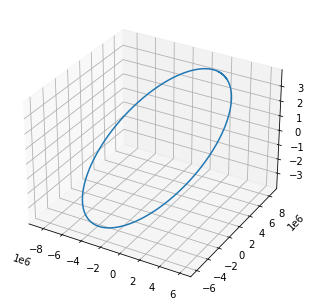

In [12]:
x = x_res[:, 0]
y = x_res[:, 1]
z = x_res[:, 2]

fig = plt.figure()
ax = p3.Axes3D(fig)
ax.plot(x, y, z)

In [13]:
r = x_res[:, :3]
V = x_res[:, 3:6]
we = x_res[:, 6:9]
A = x_res[:, 9:]

Ades = []
wdes = []
edes = []
Aerr = []
for i in range(t_points.size):
    Ade, wde, ede = desired_orientation(t_points[i], r[i], V[i], we[i], np.quaternion(*A[i]), np.quaternion(*A[i]).conj(), params)
    Aerr.append((Ade.conj() * np.quaternion(*A[i])).components)
    Ades.append(Ade.components)
    wdes.append(wde)
    edes.append(ede)
Ades = np.asarray(Ades)
wdes = np.asarray(wdes)
edes = np.asarray(edes)
Aerr = np.asarray(Aerr)

werr = we - wdes

Text(0.5, 1.0, 'Desired angular velocity')

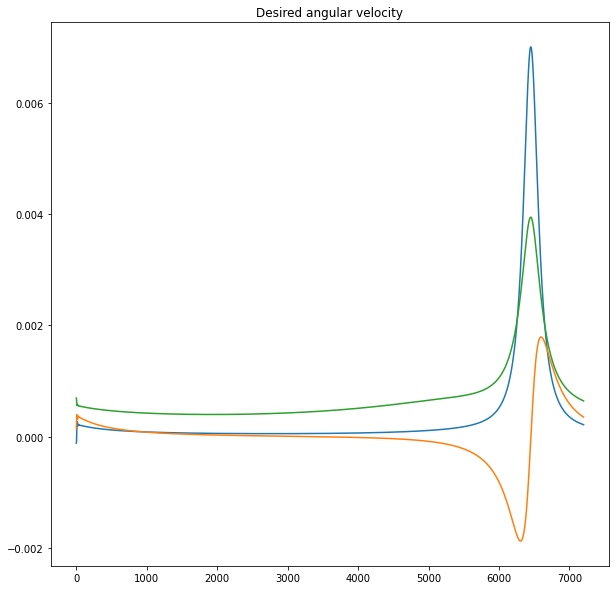

In [14]:
plt.figure(figsize=(10,10))
plt.plot(wdes)
plt.title("Desired angular velocity")

Text(0.5, 1.0, 'Desired quaternion')

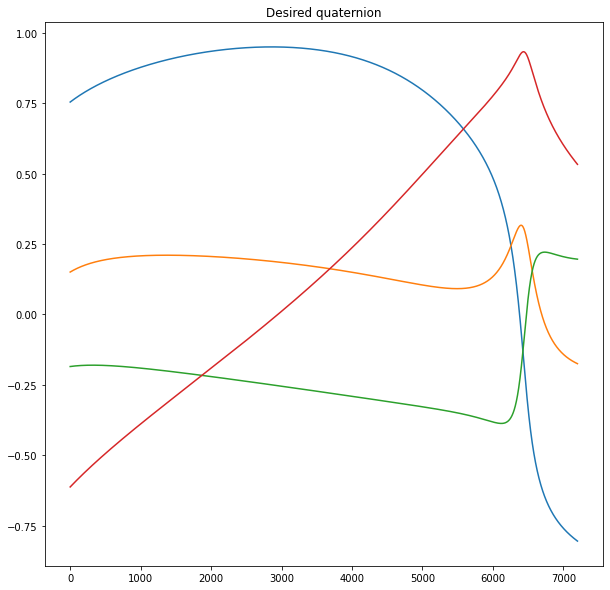

In [15]:
plt.figure(figsize=(10,10))
plt.plot(Ades)
plt.title("Desired quaternion")

Max quat. error in the end: 1.0000000000000007


(-0.01, 0.03)

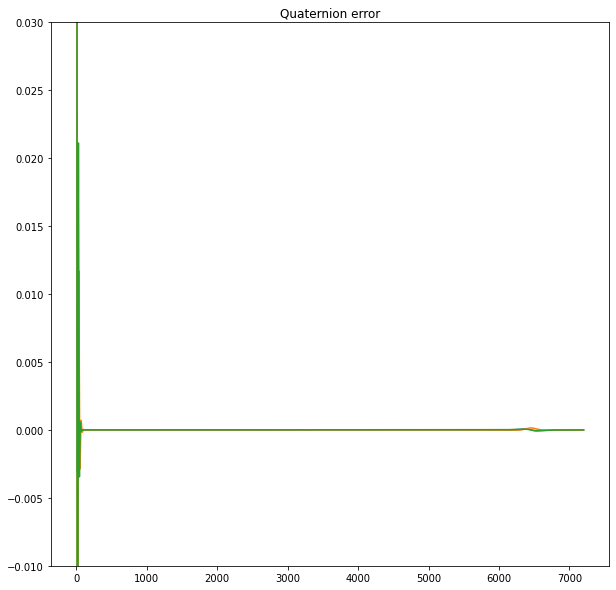

In [16]:
print("Max quat. error in the end:", np.max(np.linalg.norm(Aerr[-1000:], axis = 1)))

plt.figure(figsize=(10,10))
plt.plot(Aerr[:, 1:])
plt.title("Quaternion error")
plt.ylim((-0.01, 0.03))

Max error in the end: 5.443241556203266e-06


(0.0, 1e-05)

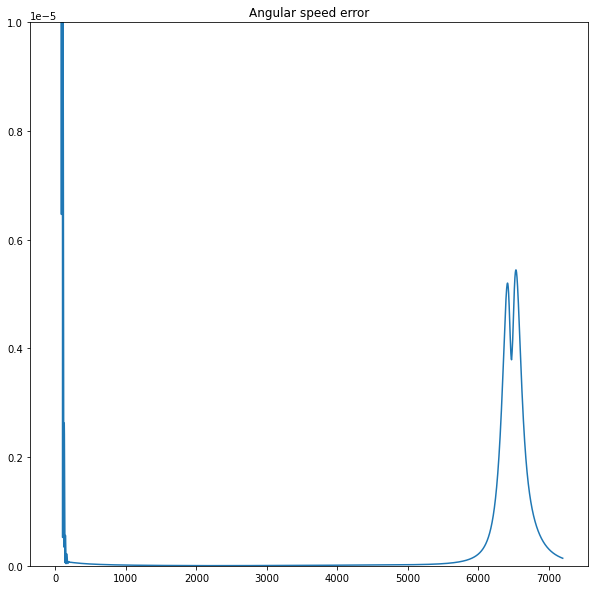

In [20]:
y = np.linalg.norm(werr, axis = 1)
print("Max error in the end:", np.max(y[-1000:]))

plt.figure(figsize=(10,10))
plt.plot(np.linalg.norm(werr, axis = 1))
plt.title("Angular speed error")
plt.ylim((0, 0.00001))